# Can Topological Divergences Help Predict the Largest Lyapunov Exponent?

## Overview

This notebook generates dynamic system trajectory data then analyses multiple features for supervised learning of the largest Lyapunov exponent (classification and regression). Classical numeric methods, TDA-based methods, Horizontal Visibility methods, and our newly introduced topological divergences are compared.

- classic neighbour-tracing estimators from Rosenstein, Eckmann, and Kantz
- ordinal partition network embedded persistence measures from Myers
- $k$-nearest neighbour graph embedded persistence measures from Myers
- Betti vector norms on embedded trajectories from Güzel
- topological divergences (the main contribution)

Topological divergences are scalar or vector valued measures of the difference between the sublevel and superlevel filtrations over a scalar function.

In [24]:
# collect imports for cells below

import numpy as np
import numpy.ma as ma
import pandas as pd
from functools import partial
from TimeSeriesMergeTreeSimple import TimeSeriesMergeTree as TSMT
from ipyparallel import require
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tree_offset_divergence import get_offset_divergences
from tree_offset_divergence import div_names as merge_tree_div_names
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.base import ClassifierMixin, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import Pipeline
from scipy.stats import iqr
from trajectories import generate_trajectories



In [2]:
# Provide clients to an ipyparallel cluster for faster parallel processing

import ipyparallel as ipp
clients = ipp.Client()
dv = clients.direct_view()
lbv = clients.load_balanced_view()

In [3]:
# Preprocessing function to remove scale bias in supervised learning

def scale(ts):
    """Make range of ts fall between 0 and 1"""
    scaler = MinMaxScaler()
    return scaler.fit_transform(ts.reshape(-1, 1)).flatten()


## Get chaotic system data

In [4]:
# Specify the trajectory generation criteria

SEED = 42  # consistent random number generation
SAMPLES = 2500  # number of trajectories
LENGTH = 500  # number of points per trajectory

In [5]:
# Generate the actual system data to analyse

system_data = generate_trajectories(RANDOM_SEED=SEED, TS_LENGTH=LENGTH, CONTROL_PARAM_SAMPLES=SAMPLES)

Experiment config -- SEED:42, LENGTH:500, SAMPLES:2500


In [6]:
# Remove relative scale (amplitude) as a feature that could be used in supevised learning

for system in system_data:
    trajectories = system_data[system]["trajectories"]
    trajectories = list(map(scale, trajectories))
    system_data[system]["trajectories"] = trajectories


## Supervised learning

In [7]:
# Define machine learning models to apply to the Lyapunov estimates
ML_SEED = 123

def score_features_train(feature_names, features, y_true, cv=5, n_repeats=5):
    """Score various supervised ML models on supplied features give a ground truth.
    
    For classification, assumes ground truth y_true>0 is the positive class.
    """

    # assume vectorial features; if scalar, add an extra dimension
    features = np.array(features)
    if features.ndim == 2:
        features = features[..., np.newaxis]
    n_samples, n_features, feature_vector_length = features.shape

    CLASSIFIER_CV = RepeatedStratifiedKFold(n_splits=cv, random_state=ML_SEED, n_repeats=n_repeats)
    REGRESSOR_CV = RepeatedKFold(n_splits=cv, random_state=ML_SEED*2, n_repeats=n_repeats)

    y = y_true
    pos_mask = y > 0

    for i in range(n_features):
        feature_name = feature_names[i]
        X = features[:, i, :].reshape(n_samples, -1)

        SVC_pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(random_state=ML_SEED))])
        SVC_clf = GridSearchCV(SVC_pipe, {'svc__C':[0.01, 0.1, 1, 10, 100]}, scoring="roc_auc", n_jobs=-2, refit=True, cv=CLASSIFIER_CV)
        SVC_clf.fit(X, y>0)
        SVC_scores = cross_val_score(SVC_clf.best_estimator_, X, y>0, scoring="roc_auc", cv=CLASSIFIER_CV, n_jobs=-2)

        KNR_all_pipe = Pipeline([('scaler', StandardScaler()), ('knr', KNeighborsRegressor())])
        KNR_all_clf = GridSearchCV(KNR_all_pipe, {'knr__n_neighbors': [10, 15, 20, 25, 30]}, n_jobs=-2, scoring="r2", cv=REGRESSOR_CV, refit=True)
        KNR_all_clf.fit(X, y)
        KNR_all_scores = cross_val_score(KNR_all_clf.best_estimator_, X, y, scoring="r2", cv=REGRESSOR_CV, n_jobs=-2)

        KNR_chaos_pipe = Pipeline([('scaler', StandardScaler()), ('knr', KNeighborsRegressor())])
        KNR_chaos_clf = GridSearchCV(KNR_chaos_pipe, {'knr__n_neighbors': [10, 15, 20, 25, 30]}, n_jobs=-2, scoring="r2", cv=REGRESSOR_CV, refit=True)
        KNR_chaos_clf.fit(X[pos_mask], y[pos_mask])
        KNR_chaos_scores = cross_val_score(KNR_chaos_clf.best_estimator_, X[pos_mask], y[pos_mask], scoring="r2", cv=REGRESSOR_CV, n_jobs=-2)

        SVR_all_pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])
        SVR_all_clf = GridSearchCV(SVR_all_pipe, {'svr__C':[0.01, 0.1, 1, 10, 100]}, scoring="r2", n_jobs=-2, refit=True, cv=REGRESSOR_CV)
        SVR_all_clf.fit(X, y)
        SVR_all_scores = cross_val_score(SVR_all_clf.best_estimator_, X, y, scoring="r2", cv=REGRESSOR_CV, n_jobs=-2)

        SVR_chaos_pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])
        SVR_chaos_clf = GridSearchCV(SVR_chaos_pipe, {'svr__C':[0.01, 0.1, 1, 10, 100]}, scoring="r2", n_jobs=-2, refit=True, cv=REGRESSOR_CV)
        SVR_chaos_clf.fit(X[pos_mask], y[pos_mask])
        SVR_chaos_scores = cross_val_score(SVR_chaos_clf, X[pos_mask], y[pos_mask], scoring="r2", cv=REGRESSOR_CV, n_jobs=-2)

        yield {
            feature_name: {
                "scores": {
                    "SVC": SVC_scores,
                    "KNR_all": KNR_all_scores,
                    "KNR_chaos": KNR_chaos_scores,
                    "SVR_all": SVR_all_scores,
                    "SVR_chaos": SVR_chaos_scores,

                },
                "models": {
                    "SVC": SVC_clf,
                    "KNR_all": KNR_all_clf,
                    "KNR_chaos": KNR_chaos_clf,
                    "SVR_all": SVR_all_clf,
                    "SVR_chaos": SVR_chaos_clf,
                }
            }
        }


In [38]:
def score_features_test(feature_names, features, y_true, trained_models):
    """Predict using features as input to trained models and score against ground truth.
    
    For classification, assumes ground truth y_true>0 is the positive class.
    """

    # assume vectorial features; if scalar, add an extra dimension
    features = np.array(features)
    if features.ndim == 2:
        features = features[..., np.newaxis]
    n_samples, n_features, feature_vector_length = features.shape
    
    y = y_true
    pos_mask = y > 0

    is_classifier = lambda clf: hasattr(clf, "classes_")

    for i in range(n_features):
        feature_name = feature_names[i]
        X = features[:, i, :].reshape(n_samples, -1)

        yield {
            feature_name: {
                "predictions": {
                    model_name: trained_model.predict(X) for model_name, trained_model in trained_models[feature_name].items()
                },
                "scores": {
                    model_name: trained_model.score(X, (y_true if not is_classifier(trained_model) else y_true > 0)) for model_name, trained_model in trained_models[feature_name].items()
                }
            }
        }

        

## Topological Divergences

First we look at topological merge tree offset path length distributions.

In [9]:
# Set up parameters for the cells below

SYSTEM = "logistic"  # current system being investigated
REP_FUNC = partial(TSMT, discrete=True)  # current mode of representing trajectories
OFFSETS = range(1,125,12)  # offsets for merge tree divergences

In [10]:
# Apply the representation constructor and get a representation of each trajectory

reps = list(map(REP_FUNC, system_data[SYSTEM]["trajectories"]))

In [11]:
# Parallelisable function to compute divergences for a single merge tree representation

@require(partial=partial, get_offset_divergences=get_offset_divergences, OFFSETS=OFFSETS)
def merge_tree_divergences(rep):
    import numpy as np
    div_values = list(map(partial(get_offset_divergences, tsmt=rep), OFFSETS))
    return np.array(div_values).T


In [12]:
# Compute the divergences for each merge tree representation in parallel

rep_divergences = lbv.map_sync(merge_tree_divergences, reps)
rep_divergences = np.array(rep_divergences)  # array of shape (n_trajectories, n_divergences, vector_length)

### Supvervised learning evaluation of divergences as features

In [14]:
# Compute the ML scores for the topological divergence features

score_results = {SYSTEM: {}}
for result in score_features_train(merge_tree_div_names, rep_divergences, system_data[SYSTEM]["lces"]):
    print(result)
    score_results[SYSTEM] |= result


{'path_length_l1': {'scores': {'SVC': array([0.96802563, 0.94493682, 0.95484501, 0.93100627, 0.95550405,
       0.96757113, 0.95457231, 0.96557131, 0.96313971, 0.93700573,
       0.94941369, 0.9728661 , 0.96627579, 0.94586856, 0.93732388,
       0.94411872, 0.95748114, 0.93786928, 0.93911917, 0.96416235,
       0.93452868, 0.95025452, 0.96716208, 0.97245705, 0.96138987]), 'KNR_all': array([0.6929791 , 0.70587498, 0.76505866, 0.6615648 , 0.70794586,
       0.69891673, 0.66902594, 0.69094391, 0.75506194, 0.67348203,
       0.68276519, 0.66464258, 0.72243606, 0.72787869, 0.73861892,
       0.64358864, 0.75135451, 0.74767702, 0.73197641, 0.67483082,
       0.73526075, 0.71488894, 0.67961084, 0.69370601, 0.70286968]), 'KNR_chaos': array([0.74098171, 0.65182897, 0.73199496, 0.54733331, 0.61606233,
       0.69556535, 0.67216271, 0.5968582 , 0.70096276, 0.62035688,
       0.73176952, 0.62895305, 0.67264246, 0.67248521, 0.60649343,
       0.6008546 , 0.70456629, 0.70873338, 0.55971083, 0.681367

### Summary of results

In [ ]:
score_results_ = {k:v["scores"] for k,v in score_results[SYSTEM].items()}
best_models_ = {k:v["models"] for k,v in score_results[SYSTEM].items()}

In [17]:
# Display the mean scores for the supervised learning using each divergence

scores_df = pd.DataFrame(score_results_)
scores_df_means = scores_df.applymap(np.mean).T
scores_df_means

,SVC,KNR_all,KNR_chaos,SVR_all,SVR_chaos
path_length_l1,0.953699,0.705318,0.656434,0.729634,0.663223
path_length_l2,0.954927,0.630569,0.570451,0.675107,0.603093
path_length_linf,0.914242,0.285017,0.397893,0.365640,0.401567
path_length_hist_w,0.983738,0.808130,0.817361,0.839171,0.790401
path_length_hist_l1,0.960235,0.576435,0.485519,0.618567,0.665668
path_length_hist_l2,0.970805,0.558781,0.471242,0.592199,0.684513
path_length_hist_linf,0.973787,0.562974,0.451398,0.572533,0.701182
cophenetic_length_l1,0.973404,0.612346,0.107136,0.626729,0.128573
cophenetic_length_l2,0.968437,0.570371,0.033199,0.567423,0.040979
cophenetic_length_linf,0.953512,0.428484,-0.011020,0.463914,0.008210


In [28]:
# Pull out the best features

best_classification_feature = scores_df_means['SVC'].idxmax()
best_classification_feature_idx = scores_df_means['SVC'].argmax()
best_regression_feature_KNR_all = scores_df_means['KNR_all'].idxmax()
best_regression_feature_KNR_all_idx = scores_df_means['KNR_all'].argmax()
best_regression_feature_KNR_chaos = scores_df_means['KNR_chaos'].idxmax()
best_regression_feature_KNR_chaos_idx = scores_df_means['KNR_chaos'].argmax()
best_regression_feature_SVR_all = scores_df_means['SVR_all'].idxmax()
best_regression_feature_SVR_all_idx = scores_df_means['SVR_all'].argmax()
best_regression_feature_SVR_chaos = scores_df_means['SVR_chaos'].idxmax()
best_regression_feature_SVR_chaos_idx = scores_df_means['SVR_chaos'].argmax()

(
    best_classification_feature, best_classification_feature_idx,
    best_regression_feature_KNR_all, best_regression_feature_KNR_all_idx,
    best_regression_feature_KNR_chaos, best_regression_feature_KNR_chaos_idx,
    best_regression_feature_SVR_all, best_regression_feature_SVR_all_idx,
    best_regression_feature_SVR_chaos, best_regression_feature_SVR_chaos_idx,
)

('path_weight_hist_l2',
 19,
 'path_weight_hist_w',
 17,
 'path_weight_hist_w',
 17,
 'path_weight_hist_l2',
 19,
 'path_weight_hist_w',
 17)

In [29]:
scores_df[best_classification_feature]["SVC"]

array([0.99009181, 0.99011454, 0.99579584, 0.99306881, 0.97904736,
       0.99511408, 0.98825107, 0.98816017, 0.98443323, 0.9920689 ,
       0.97834288, 0.99740933, 0.98968276, 0.99145532, 0.98861467,
       0.99159167, 0.99740933, 0.98529679, 0.98491046, 0.99011454,
       0.98569448, 0.99779565, 0.98579675, 0.99154622, 0.9867512 ])

### Predictions

To illustrate the predictive power of the resulting feature(s) we use computed divergences for training and predict $\lambda_{\max}$ for new unseen trajectories.

#### Test Data

In [18]:
# Set up test data for predictions, different to the training and validation data used above

system_data_for_prediction = generate_trajectories(RANDOM_SEED=SEED*2, TS_LENGTH=LENGTH, CONTROL_PARAM_SAMPLES=1000)
test_trajectories = system_data_for_prediction[SYSTEM]["trajectories"]
test_param_name = system_data_for_prediction[SYSTEM]["param_name"]
test_params = system_data_for_prediction[SYSTEM]["sys_params"]
y_test = system_data_for_prediction[SYSTEM]["lces"]

Experiment config -- SEED:84, LENGTH:500, SAMPLES:1000


#### Features

In [19]:
# Compute divergences for each merge tree representation of test data in parallel

test_reps = list(map(REP_FUNC, test_trajectories))
test_rep_divergences = lbv.map_sync(merge_tree_divergences, test_reps)
test_rep_divergences = np.array(test_rep_divergences)  # array of shape (n_trajectories, n_divergences, vector_length)

In [47]:
# Sanity check the ML scores for the topological divergence features of the test set separately

test_score_results = {SYSTEM: {}}
for result in score_features_test(merge_tree_div_names, test_rep_divergences, y_test, best_models_):
    print(result)
    test_score_results[SYSTEM] |= result


{'path_length_l1': {'predictions': {'SVC': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False,  True,
       False, False,  True, False, False, False

In [48]:
test_score_results_ = {k:v["scores"] for k,v in test_score_results[SYSTEM].items()}
test_score_predictions_ = {k:v["predictions"] for k,v in test_score_results[SYSTEM].items()}

In [45]:
# Display the mean scores for the supervised learning using each divergence

test_scores_df = pd.DataFrame(test_score_results_)
test_scores_df_means = test_scores_df.applymap(np.mean).T
test_scores_df_means

,SVC,KNR_all,KNR_chaos,SVR_all,SVR_chaos
path_length_l1,0.949621,0.682840,-0.592387,0.703898,-0.196353
path_length_l2,0.947758,0.635946,-0.512260,0.630507,-0.255870
path_length_linf,0.769124,0.003611,-0.191279,0.060854,-0.250864
path_length_hist_w,0.983108,0.748731,-0.525342,0.797574,0.173126
path_length_hist_l1,0.941346,0.396841,-0.525946,0.449213,-0.044712
path_length_hist_l2,0.940617,0.411399,-0.410947,0.443127,-0.027173
path_length_hist_linf,0.962757,0.452768,-0.319960,0.464874,0.006855
cophenetic_length_l1,0.963344,0.578092,-0.362614,0.530579,-0.232535
cophenetic_length_l2,0.959446,0.517591,-0.309309,0.501175,-0.273080
cophenetic_length_linf,0.879513,0.224798,-0.177676,0.270948,-0.244241


#### Visualisation

In [52]:
prediction_feature = "cophenetic_weight_hist_l2"
prediction_model = "SVR_all"
y_pred = test_score_predictions_[prediction_feature][prediction_model]
y_pred

array([-3.78694557e-01, -3.78694557e-01, -3.78694557e-01, -3.78694557e-01,
       -3.78694557e-01, -3.78694557e-01, -4.30487617e-01, -4.30487617e-01,
       -3.78694557e-01, -3.78694557e-01, -4.30487617e-01, -3.78694557e-01,
       -4.30487617e-01, -4.49019768e-01, -3.78694557e-01, -3.78694557e-01,
       -3.78694557e-01, -4.47283273e-01, -3.78694557e-01, -3.78694557e-01,
       -3.42680357e-01, -3.78694557e-01, -4.30487617e-01, -3.78694557e-01,
       -3.78694557e-01, -4.30487617e-01, -4.30487617e-01, -3.83775458e-01,
       -4.30487617e-01, -3.83775458e-01, -3.78694557e-01, -3.71152433e-01,
       -9.27025134e-02, -3.32596275e-02, -2.48897138e-02,  4.93869520e-03,
       -8.41630398e-02, -1.02444727e-02, -1.54118351e-01, -1.54118351e-01,
       -1.54118351e-01, -1.24780673e-01, -1.03376500e-01, -8.89473229e-02,
       -1.03376500e-01, -1.03376500e-01, -1.03376500e-01, -1.03376500e-01,
       -1.03376500e-01, -1.03376500e-01, -1.03376500e-01, -1.03376500e-01,
       -1.03376500e-01, -

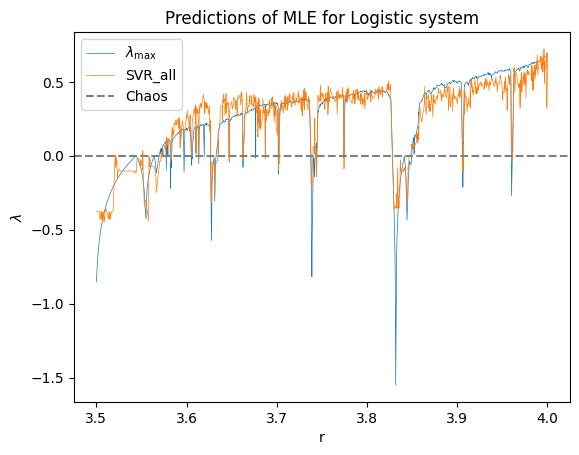

In [53]:
# plot the ground truth and regression predictions
plt.plot(test_params, y_test, lw=0.5, label=r"$\lambda_{\max}$")
plt.plot(test_params, y_pred, lw=0.5, label=prediction_model)
plt.xlabel(test_param_name)
plt.ylabel(r"$\lambda$")
plt.axhline(y=0, color='grey', linestyle='--', label='Chaos')
plt.legend()
plt.title(f"Predictions of MLE for {SYSTEM.capitalize()} system")
plt.show()


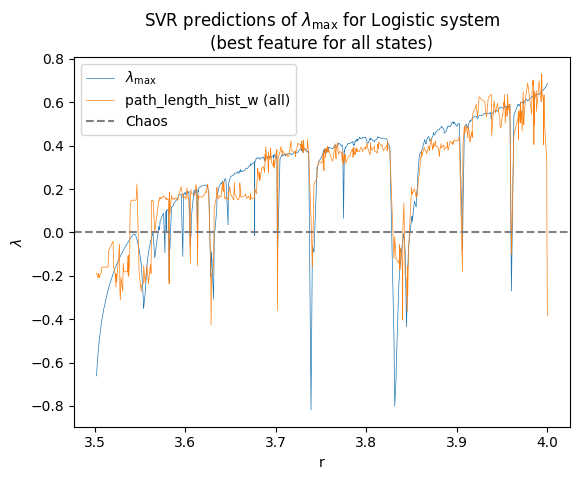

In [29]:
# plot the ground truth and regression predictions
plt.plot(test_params, y_test, lw=0.5, label=r"$\lambda_{\max}$")
plt.plot(test_params, y_pred_SVR_regression_all, lw=0.5, label=f"{best_regression_feature_SVR_all} (all)")
# plt.plot(test_params, y_pred_regression_chaos, lw=0.5, label=f"{best_correlation_chaos} (chaos)")

plt.xlabel(test_param_name)
plt.ylabel(r"$\lambda$")
plt.axhline(y=0, color='grey', linestyle='--', label='Chaos')
plt.legend()
plt.title(r"SVR predictions of $\lambda_{\max}$ for " + SYSTEM.capitalize() + " system\n(best feature for all states)")
plt.show()


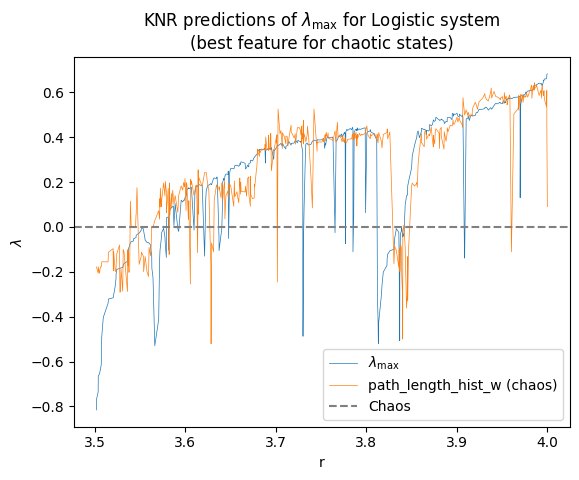

In [30]:
# plot the ground truth and regression predictions
plt.plot(test_params, y, lw=0.5, label=r"$\lambda_{\max}$")
plt.plot(test_params, y_pred_KNR_regression_chaos, lw=0.5, label=f"{best_regression_feature_KNR_chaos} (chaos)")

plt.xlabel(test_param_name)
plt.ylabel(r"$\lambda$")
plt.axhline(y=0, color='grey', linestyle='--', label='Chaos')
plt.legend()
plt.title(r"KNR predictions of $\lambda_{\max}$ for " + SYSTEM.capitalize() + " system\n(best feature for chaotic states)")
plt.show()


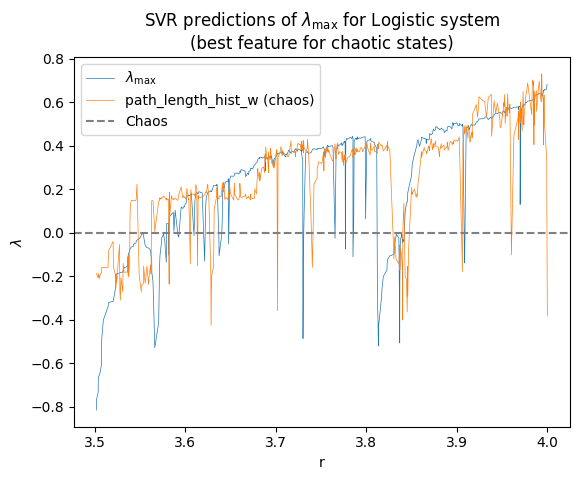

In [31]:
# plot the ground truth and regression predictions
plt.plot(test_params, y, lw=0.5, label=r"$\lambda_{\max}$")
plt.plot(test_params, y_pred_SVR_regression_chaos, lw=0.5, label=f"{best_regression_feature_SVR_chaos} (chaos)")

plt.xlabel(test_param_name)
plt.ylabel(r"$\lambda$")
plt.axhline(y=0, color='grey', linestyle='--', label='Chaos')
plt.legend()
plt.title(r"SVR predictions of $\lambda_{\max}$ for " + SYSTEM.capitalize() + " system\n(best feature for chaotic states)")
plt.show()


In [32]:
np.all(y_pred_classification)

False

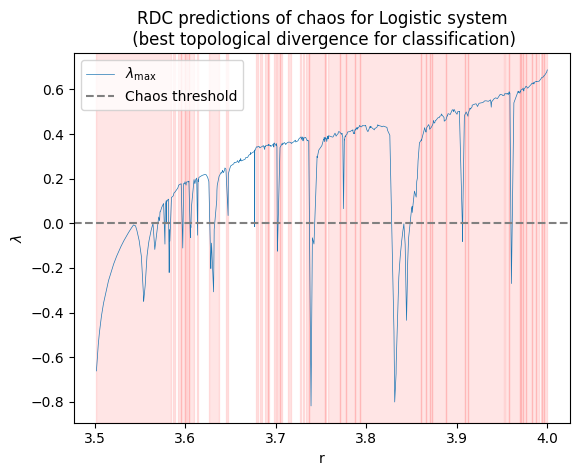

In [33]:
# plot the ground truth
plt.plot(test_params, y_test, lw=0.5, label=r"$\lambda_{\max}$")

# plot the classification predictions as vspans over the graph
predicted_non_chaos = y_pred_classification <= 1e-3
x = test_params

# mark sections of the x-axis where predicted_non_chaos is True
start = x[0] if predicted_non_chaos[0] else None
for i in range(1, len(predicted_non_chaos)):
    if not predicted_non_chaos[i-1] and predicted_non_chaos[i]:
        start = x[i-1]
    elif predicted_non_chaos[i-1] and not predicted_non_chaos[i]:
        if start is not None:
            plt.axvspan(start, x[i], color='red', alpha=0.1)
            start = None
    elif i == len(predicted_non_chaos)-1 and not predicted_non_chaos[i]:  # case for the end of the array
        if start is not None:
            plt.axvspan(start, x[i], color='red', alpha=0.1)

plt.xlabel(test_param_name)
plt.ylabel(r"$\lambda$")
plt.axhline(y=0, color='grey', linestyle='--', label='Chaos threshold')
plt.legend()
plt.title(r"RDC predictions of chaos for " + SYSTEM.capitalize() + " system\n (best topological divergence for classification)")
plt.show()


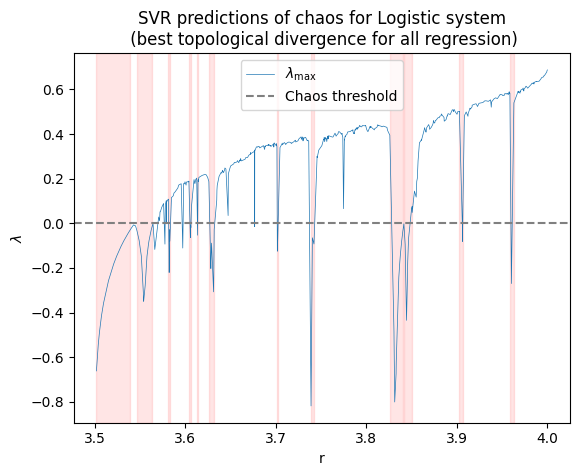

In [34]:
# plot the ground truth
plt.plot(test_params, y_test, lw=0.5, label=r"$\lambda_{\max}$")

# plot the classification predictions as vspans over the graph
predicted_non_chaos = y_pred_SVR_regression_all <= 1e-3
x = test_params

# mark sections of the x-axis where predicted_non_chaos is True
start = x[0] if predicted_non_chaos[0] else None
for i in range(1, len(predicted_non_chaos)):
    if not predicted_non_chaos[i-1] and predicted_non_chaos[i]:
        start = x[i-1]
    elif predicted_non_chaos[i-1] and not predicted_non_chaos[i]:
        if start is not None:
            plt.axvspan(start, x[i], color='red', alpha=0.1)
            start = None
    elif i == len(predicted_non_chaos)-1 and not predicted_non_chaos[i]:  # case for the end of the array
        if start is not None:
            plt.axvspan(start, x[i], color='red', alpha=0.1)

plt.xlabel(test_param_name)
plt.ylabel(r"$\lambda$")
plt.axhline(y=0, color='grey', linestyle='--', label='Chaos threshold')
plt.legend()
plt.title(r"SVR predictions of chaos for " + SYSTEM.capitalize() + " system\n (best topological divergence for all regression)")
plt.show()


### Hyperparameters of the divergence-based estimates

The following can be considered for variation in a wider-range study.

- Offset range and step size - equivalently offset range and number of offsets
- Dimension of the histogram vectors being compared
- Discrete vs piecewise linear merge trees


## Classic Estimators

In [40]:
from classic_estimators import get_classic_estimates, classic_names

In [50]:
classic_estimates_list = list(lbv.map_sync(get_classic_estimates, system_data[SYSTEM]["trajectories"]))

In [222]:
classic_estimates = np.array(classic_estimates_list)

In [223]:
def make_inf_column_finite(arr):
    """Convert -inf and +inf to min and max finite values in each column."""

    arr_isinf = np.isinf(arr)
    col_mins = np.min(ma.masked_array(arr, mask=arr_isinf, fill_value=0), axis=0)

    for row_idx in range(arr.shape[0]):
        for col_idx in range(arr.shape[1]):
            if np.isinf(arr[row_idx, col_idx]):
                arr[row_idx, col_idx] = col_mins[col_idx]
                arr[np.isnan(arr)] = -1e-12

    return arr

In [224]:
classic_estimates_finite = make_inf_column_finite(classic_estimates)

In [225]:
classic_estimates_finite

array([[-2.62466485e-01, -2.41580665e-01, -2.51436059e+01],
       [-2.62466485e-01, -2.41580665e-01, -2.51436059e+01],
       [-2.62466485e-01, -2.41580665e-01, -2.51436059e+01],
       ...,
       [ 9.76280795e-03,  4.55756396e-01,  2.78699939e-01],
       [ 1.04262404e-03,  4.22874779e-01,  1.61333506e-01],
       [-2.60043521e-03,  4.08968002e-01,  1.77417111e-01]])

In [226]:
classic_results = {SYSTEM: {}}
for result in score_features_train(classic_names, classic_estimates[..., np.newaxis], system_data[SYSTEM]):
    print(result)
    classic_results[SYSTEM] |= result

{'Rosenstein': {'SVC': array([0.97149123, 0.98135965, 1.        , 0.94901316, 1.        ,
       0.96107456, 0.9566886 , 0.98355263, 0.99945175, 1.        ,
       0.9375    , 0.98629386, 0.99945175, 0.98135965, 0.99830604,
       0.95833333, 1.        , 0.97149123, 0.98190789, 0.98531903,
       0.97807018, 0.97861842, 0.99890351, 0.98190789, 0.95652174,
       0.98190789, 0.95997807, 0.97039474, 0.99890351, 0.98362507,
       1.        , 0.95888158, 0.96765351, 0.98026316, 1.        ,
       0.97039474, 0.95778509, 0.98410088, 0.98574561, 1.        ,
       0.98300439, 0.99232456, 0.97752193, 0.98464912, 0.95652174,
       1.        , 0.98574561, 0.97532895, 0.95339912, 0.9785432 ]), 'KNR_all': array([0.79698685, 0.61846223, 0.68079772, 0.69577517, 0.64700781,
       0.64782013, 0.74131532, 0.72940426, 0.81721319, 0.57329006,
       0.65452947, 0.78539534, 0.69851874, 0.71827225, 0.67767247,
       0.69203818, 0.77168574, 0.67905355, 0.71420727, 0.6476815 ,
       0.53993811, 0.77178

In [227]:
# Display the mean scores for the supervised learning using each divergence

classic_scores_df = pd.DataFrame(classic_results[SYSTEM])
classic_scores_df_means = classic_scores_df.applymap(np.mean).T
classic_scores_df_means

,SVC,KNR_all,KNR_chaos,SVR_all,SVR_chaos
Rosenstein,0.979666,0.701682,0.026834,0.637751,0.055674
Eckmann,0.941171,0.723599,0.329909,0.718826,0.340700
Kantz,0.992202,0.680461,0.709726,0.830417,0.704635


In [228]:
# Also compute scores for "direct" estimation using the classic features - since the values are direct estimates

rosenstesin_class_score = roc_auc_score(system_data[SYSTEM]["lces"]>0, classic_estimates[:,0]>0)
eckmann_class_score = roc_auc_score(system_data[SYSTEM]["lces"]>0, classic_estimates[:,1]>0)
kantz_class_score = roc_auc_score(system_data[SYSTEM]["lces"]>0, classic_estimates[:,2]>0)

In [229]:
rosenstesin_class_score, eckmann_class_score, kantz_class_score

(0.8900174242925516, 0.6722689075630253, 0.7650918635170604)

In [230]:
# Also compute scores for "direct" estimation using the classic features - since the values are direct estimates

rosenstesin_regress_score = r2_score(system_data[SYSTEM]["lces"], classic_estimates[:,0])
eckmann_regress_score = r2_score(system_data[SYSTEM]["lces"], classic_estimates[:,1])
kantz_regress_score = r2_score(system_data[SYSTEM]["lces"], classic_estimates[:,2])

In [231]:
rosenstesin_regress_score, eckmann_regress_score, kantz_regress_score

(-0.2960974041183295, -3.616091698385886, -1422.8203937269932)

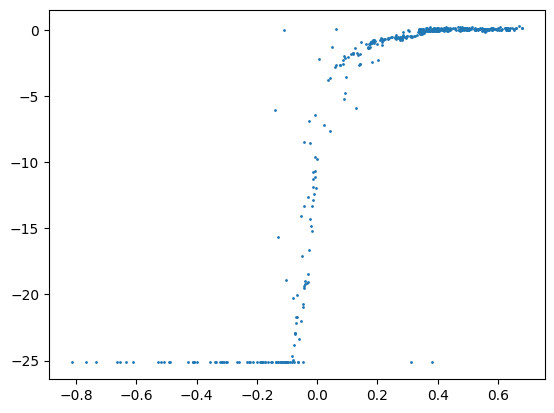

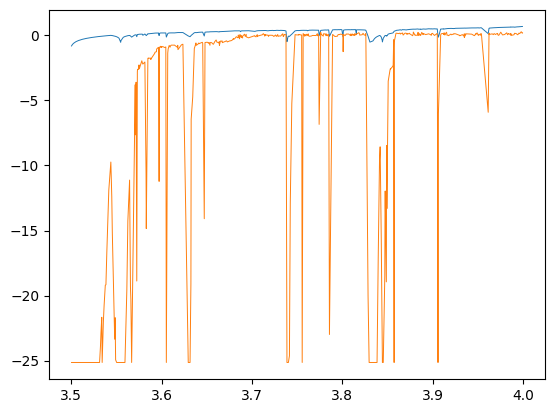

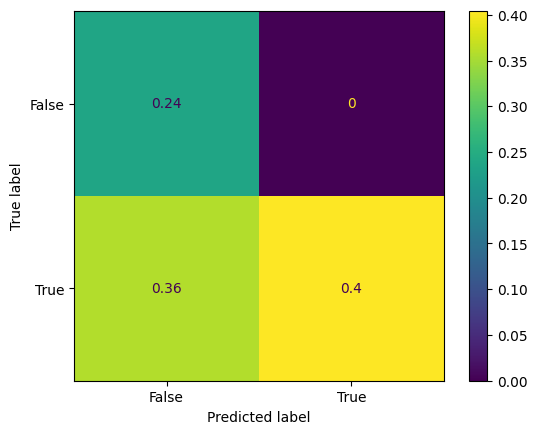

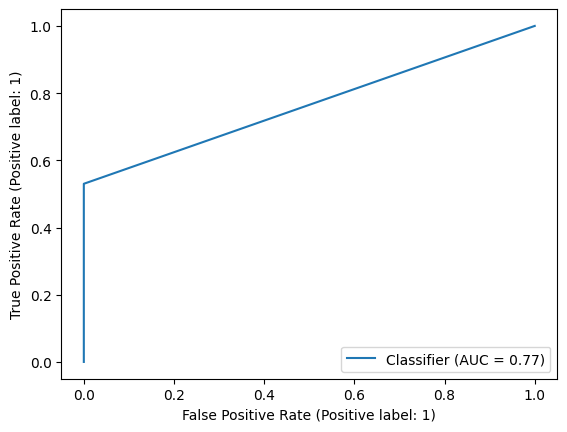

In [232]:
estimates = classic_estimates_finite[:,2]
# estimates = y_pred_SVR_regression_chaos
plt.scatter(y_train, estimates, s=1)
plt.show()
plt.plot(system_data[SYSTEM]["sys_params"], y_train, lw=0.7)
plt.plot(system_data[SYSTEM]["sys_params"], estimates, lw=0.7)
plt.show()
conf_mat = confusion_matrix(y_train>0, estimates>0, normalize='all')
ConfusionMatrixDisplay.from_predictions(y_train>0, estimates>0, normalize='all')
plt.show()
RocCurveDisplay.from_predictions(y_train>0, estimates>0)
plt.show()